# Reproject Raster Data with Rioxarray
We will learn to line up rasters in different, known CRSs

## Raster Projection in Python
If you loaded two rasters with different projections into QGIS or ArcGIS, you'd see that they would align. But with R or Python, you'll need to reproject the data yourself.

The DSM we've worked with so far includes the tops of trees, while the DTM we will be working with this time shows the ground level. Our goal is to get these data into the same projection with the `rioxarray.reproject_match()` function so we can calculate tree canopy height, CHM. 

First, we must read in both rasters.

In [1]:
import rioxarray

surface_HARV = rioxarray.open_rasterio("data/NEON-GEO-PYTHON-DATASETS/NEON-DS-Airborne-Remote-Sensing/HARV/DSM/HARV_dsmCrop.tif")
terrain_HARV = rioxarray.open_rasterio("data/NEON-GEO-PYTHON-DATASETS/NEON-DS-Airborne-Remote-Sensing/HARV/DTM/HARV_dtmCrop_WGS84.tif")
surface_HARV

<xarray.DataArray (band: 1, y: 1367, x: 1697)>
[2319799 values with dtype=float64]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 7.315e+05 7.315e+05 ... 7.331e+05 7.331e+05
  * y            (y) float64 4.714e+06 4.714e+06 ... 4.712e+06 4.712e+06
    spatial_ref  int64 0
Attributes:
    STATISTICS_MAXIMUM:  416.06997680664
    STATISTICS_MEAN:     359.85311802914
    STATISTICS_MINIMUM:  305.07000732422
    STATISTICS_STDDEV:   17.83169335933
    _FillValue:          -9999.0
    scale_factor:        1.0
    add_offset:          0.0

You can view the CRS information in the interactive `repr`. Click on the document icon on the right side of the `spatial_ref` row. 

We can also use the CRS class in the `pyproj` library to view the CRS.

In [2]:
from pyproj import CRS

CRS(surface_HARV.rio.crs)

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can see the datum and projection are UTM zone 18N and WGs 84. UTM zone 18N is a regional projection with an associated coordinate system to more accurately capture distance, shape, ad/or area around the Harvard Forest.

In [3]:
CRS(terrain_HARV.rio.crs)

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can see that the DTM is in an unprojected geographic coordinate system, using WGS84 as the datum and a coordinate system that spans the entire planet. This means that every location on the planet is defined using the same coordinate system and units. Geographic coordinate reference systems are good for global analysis, but not on a local scale.

We can use the CRS attribute from one of our datasets to reproject the other dataset. The only argument that is required is the `reproject_match` argument, which takes the CRS of the result of the reprojection.

In [4]:
terrain_HARV_UTM18 = terrain_HARV.rio.reproject_match(surface_HARV)
terrain_HARV_UTM18

<xarray.DataArray (band: 1, y: 1367, x: 1697)>
array([[[  389.3999939 ,   389.54998779,   389.47998047, ...,
         -9999.        ,   344.97000122,   345.13000488],
        [  389.3999939 ,   389.44998169,   389.3500061 , ...,
           345.20999146,   344.97000122,   345.13000488],
        [  388.95999146,   389.19000244,   389.22998047, ...,
           345.07000732,   344.98999023,   345.1000061 ],
        ...,
        [  344.47000122,   344.50997925,   344.52999878, ...,
           309.3999939 ,   309.3500061 ,   309.17999268],
        [  344.42999268,   344.47000122,   344.51998901, ...,
           309.26998901,   309.25      ,   309.29998779],
        [  344.41000366,   344.47000122,   344.52999878, ...,
         -9999.        , -9999.        ,   309.3500061 ]]])
Coordinates:
  * x            (x) float64 7.315e+05 7.315e+05 ... 7.331e+05 7.331e+05
  * y            (y) float64 4.714e+06 4.714e+06 ... 4.712e+06 4.712e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    -9999.0

`reproject_match` does a lot of helpful things:
   1. It reprojects`terrain_HARV` from WGS 84 to UTM Zone 18
   2. Where `terrain_HARV` has data values and `surface_HARV` does not, the result `terrain_HARV_UTM18` is clipped. Where surface_HARV has data values and `terrain_HARV` does not, the result `terrain_HARV_UTM18` is padded with no data values to match the extent.
   3. It sets the no data value of `terrain_HARV` to that of `surface_HARV`
   
There is also a method called `reproject()`, which only reprojects one raster to another projection (without needing to specify another raster to match). If you want more control over how rasters are resampled, clipped, and/or reprojected, you can use the `reproject()` method and other `rioxarray` methods individually.

We can also save our DataArray that we created with `rioxarray` to a file.

In [5]:
reprojected_path = "data/NEON-GEO-PYTHON-DATASETS/NEON-DS-Airborne-Remote-Sensing/HARV/DTM/HARV_dtmCrop_UTM18.tif"
terrain_HARV_UTM18.rio.to_raster(reprojected_path)

In [7]:
CRS(terrain_HARV_UTM18.rio.crs)

<Derived Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
# viewing the data sets' crs:
print(terrain_HARV_UTM18.rio.crs)
print(surface_HARV.rio.crs)

# viewing the data sets' nodata:
print(terrain_HARV_UTM18.rio.nodata)
print(surface_HARV.rio.nodata)

# viewing the data sets' extents (shapes):
print(terrain_HARV_UTM18.shape)
print(surface_HARV.shape)

EPSG:32618
EPSG:32618
-9999.0
-9999.0
(1, 1367, 1697)
(1, 1367, 1697)


As can be seen, the CRSs, shapes, and nodata values are the same. This means we can run calculations on these two DataArrays.

Let's plot what we have so far. We can use the `xarray.DataArray.plot` function to show the DTM. But, something doesn't look right ...

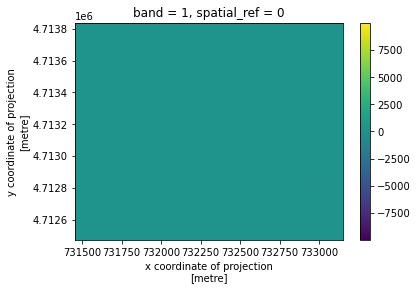

In [12]:
terrain_HARV_UTM18.plot(cmap="viridis")

Our array has a `nodata` value, -9999.0, which causes the color of the plot to be stretched over too wide a range. We'd like to only display valid values, so before plotting, we can filter out the nodata values using the `where()` function and the `.rio.nodata` attribute of our DataArray

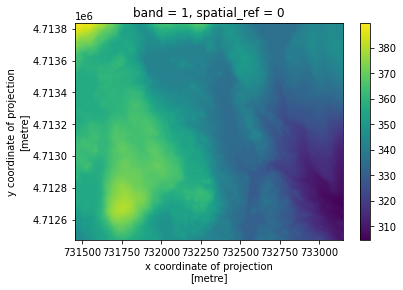

In [15]:
terrain_HARV_UTM18_valid = terrain_HARV_UTM18.where(terrain_HARV_UTM18 != terrain_HARV_UTM18.rio.nodata)
terrain_HARV_UTM18_valid.plot(cmap="viridis")

If we had saved `terrain_HARV_UTM18` to a file and read it with the `masked=True` argument, the raster's nodata value would be masked and we would not need to use the `where()` function to do the masking before plotting.

There are many ways to improve this plot. Matplotlib offers lots of different functiosn to change the position and appearance of plot elements. To plot with Matplotlib, you need to import the `pyplot` module. 

Let's add a title. This can be done with the `plt.title()` function.

Text(0.5, 1.0, 'Harvard Forest Digital Terrain Model')

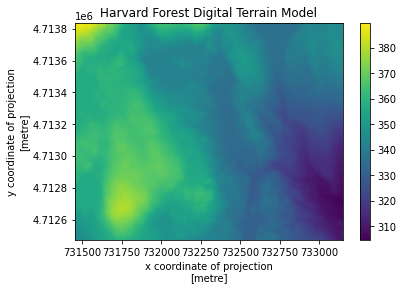

In [16]:
import matplotlib.pyplot as plt
terrain_HARV_UTM18_valid.plot()
plt.title("Harvard Forest Digital Terrain Model")

Look for other ways to customize your plot with Matplotlib. For example, with the `plt.style.use()` function. You can check available styles with `plt.style.available`.

Another useful function is `plt.ticklabel_format(style="plain")`. This will ensure our ticks are not truncated, making our pot nicer.

In [17]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Text(0.5, 1.0, 'Harvard Forest Digital Terrain Model')

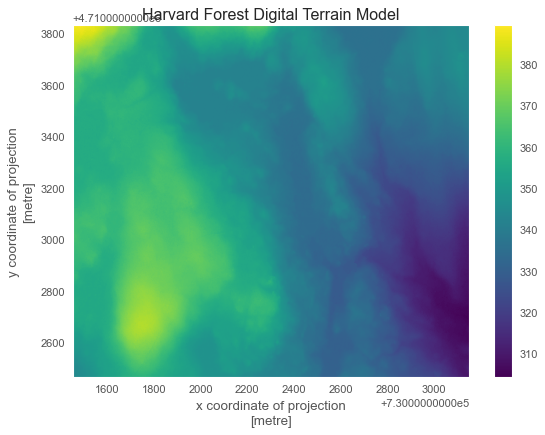

In [38]:
plt.style.use("ggplot")
terrain_HARV_UTM18_valid.plot()
plt.ticklabel_format(style="plain")
plt.title("Harvard Forest Digital Terrain Model")

Notice that `plt.style.use()` comes before both `plt.title()` and `plt.ticklabel_format` come after the `.plot()` functiion. This is beause `plt.style.use()` is a `pyplot` wide setting, while the latter two functions apply only to our current figure.

Quick tip: for all following plots, use the `plt.title` and `plt.ticklabel_format` functions.

## Challenge: Reproject, then Plot a Digital Terrain Model
Create 2 maps in a UTM projection of the San Joaquin Experimental Range field site, using theSJER_dtmCrop.tif and SJER_dsmCrop_WGS84.tif files. Use rioxarray and matplotlib.pyplot (to add a title). Reproject the data as necessary to make sure each map is in the same UTM projection and save the reprojected file with the file name “data/NEON-DS-Airborne-Remote-Sensing/SJER/DSM/SJER_dsmCrop_WGS84.tif”.

In [45]:
# imports pyproj to see CRS data
from pyproj import CRS

In [78]:
# loads in rasters
filepath = "data/NEON-GEO-PYTHON-DATASETS/NEON-DS-Airborne-Remote-Sensing/SJER/DTM/SJER_dtmCrop.tif"
terrain_SJER = rioxarray.open_rasterio(filepath, masked=True)
filepath = "data/NEON-GEO-PYTHON-DATASETS/NEON-DS-Airborne-Remote-Sensing/SJER/DSM/SJER_dsmCrop_WGS84.tif"
surface_SJER = rioxarray.open_rasterio(filepath, masked=True)

In [79]:
# displays CRSs
CRS(terrain_SJER.rio.crs)

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [80]:
# displays CRSs
CRS(surface_SJER.rio.crs)

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [81]:
# reprojects surface model
reprojected_surface = surface_SJER.rio.reproject(dst_crs=terrain_SJER.rio.crs)
reprojected_surface

<xarray.DataArray (band: 1, y: 2280, x: 2118)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * x            (x) float64 2.556e+05 2.556e+05 ... 2.578e+05 2.578e+05
  * y            (y) float64 4.112e+06 4.112e+06 ... 4.109e+06 4.109e+06
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

Text(0.5, 1.0, 'SJER Reprojected Surface Model')

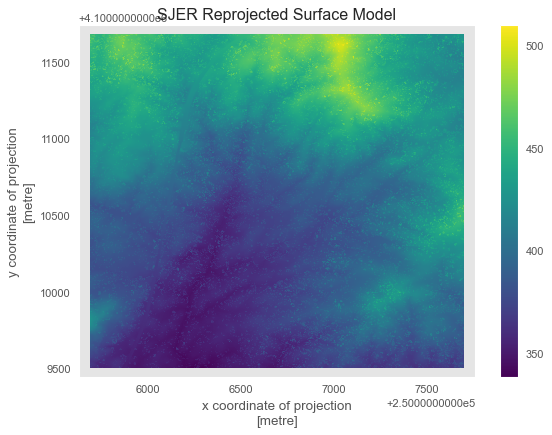

In [82]:
# plots the new raster, with a title and no ticks
reprojected_surface.plot()
plt.title("SJER Reprojected Surface Model")

In [83]:
# saves the new raster to a file
reprojected_path = "data/NEON-GEO-PYTHON-DATASETS/NEON-DS-Airborne-Remote-Sensing/SJER/DSM/SJER_dsmCrop_WGS84.tif"
reprojected_surface.rio.to_raster(reprojected_path)

Text(0.5, 1.0, 'SJER Terrain Model')

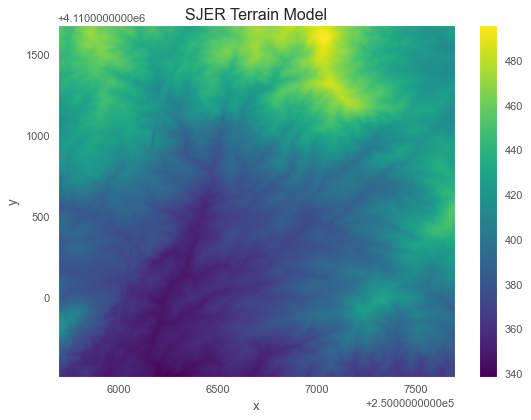

In [84]:
# plots the terrain model
terrain_SJER.plot()
plt.title("SJER Terrain Model")